# To do 
- add choosing gpus 
- add random seed for all ( from server code) ( add it to github) 
- implement baseline transformer  
- start train with it 
- connect with git cleaned version. The smartest version of my code and thoughts . 
- make report 


- add images of prediction and true only in case better corrs.( also save in that situation)
- add corr mean calculation for train.

# Install libraries 


In [2]:
import sys, os
import mne, sklearn, wandb
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker


# animation part
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation



## torch libraries 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils import get_datasets
from utils import preproc
from utils import torch_dataset
from utils import train_utils
from utils import inference
from utils.models_arch import autoencoder_v3

ImportError: cannot import name 'autoencoder_v3' from 'utils.models_arch' (unknown location)

# Set all hyperparameters
Parameters of dataset, random seed and so on 


# Upload dataset 
Upload EEG fMRI and labels 

In [6]:
# patient = 'trio1'
# path_to_dataset = '../data/eyes_open_closed_dataset/'
# dataset_name = 'CWL'
# remove_confounds = True
# # common/koval_alvi/fmri_eeg_project/


# df_eeg, df_fmri, labels_roi = get_datasets.download_cwl_dataset(patient, path_to_dataset, 
#                                                                     remove_confounds=remove_confounds,
#                                                                     verbose=True)
# df_eeg_align, df_fmri_interp, fps = get_datasets.interpolate_df_eeg_fmri(df_eeg, df_fmri)


patient = '32'
path_to_dataset = '../data/NODDI_dataset_light/'
dataset_name = 'NODDI'
remove_confounds = True



raw, df_eeg, df_fmri, labels_roi = get_datasets.download_bids_noddi_dataset(patient, path_to_dataset, 
                                                                    remove_confounds=remove_confounds,
                                                                    verbose=True)
df_eeg_align, df_fmri_interp, fps = get_datasets.interpolate_df_eeg_fmri(df_eeg, df_fmri)

ALL path:  ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_desc-confounds_timeseries.tsv ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json ../data/NODDI_dataset_light/derivatives/sub-32/eeg/sub-32_task-rest_eeg.vhdr


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:392: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(eeg_preproc_path, preload=True, verbose=False)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:392: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(eeg_preproc_path, preload=True, verbose=False)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:393: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  raw.set_channel_types({'ECG': 'ecg'})


Dimension of our EEG data:  (162023, 64)
Dimension of our fMRi data:  (97, 115, 97, 300)
Dimension of our fMRi Roi data:  (300, 18)
fMRI info: {'RepetitionTime': 2.16, 'SkullStripped': False, 'SliceTimingCorrected': True, 'StartTime': 1.049, 'TaskName': 'rest'}
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']


<AxesSubplot:xlabel='time'>

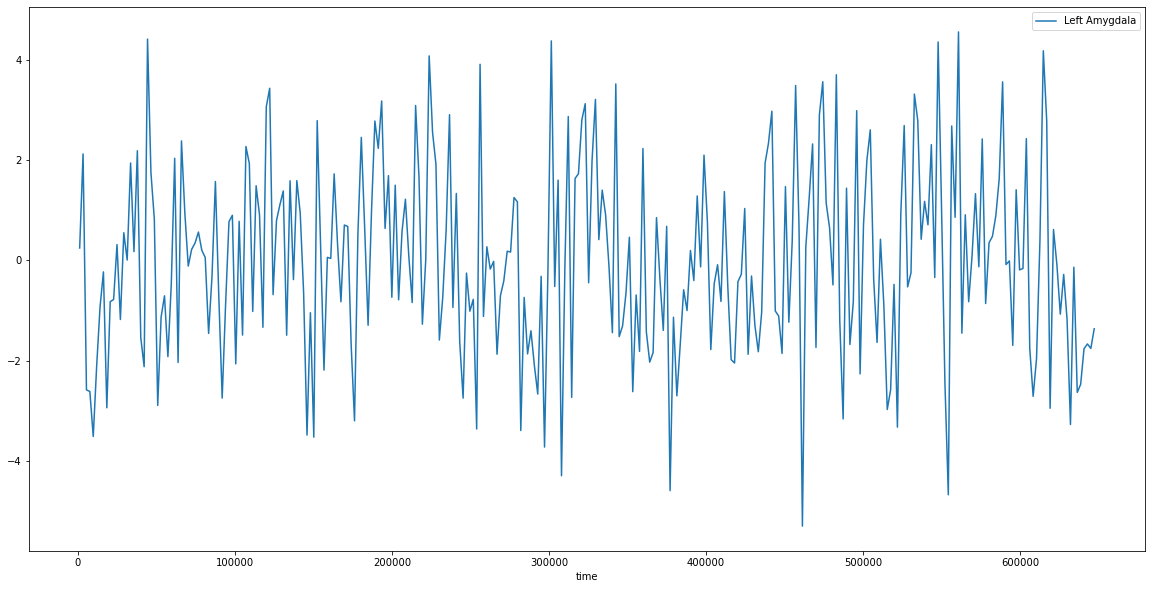

In [74]:
# plt.figure(figsize = (20, 10))
df_fmri.plot(x = 'time', y = ['Left Amygdala'], figsize = (20, 10))

In [ ]:
raw

In [13]:
times_fmri = []
for annot in raw.annotations:
    if annot['description'] == "Scanner/Scan Start":
        times_fmri.append(annot['onset'])

times_fmri = np.array(times_fmri)
times_fmri = times_fmri * 1000  # seconds to milliseconds



# Process data
- divide on train and test 
- Process data separately
- Downsample if needed.
- apply bold delay correction

In [47]:
config = dict(  
                dataset_name = dataset_name,
                fps=fps,
                new_fps=250,
                n_channels = 64, # 30
                n_roi = 21,
                test_sec = 60, # in seconds.
                freqs = np.linspace(2, 100, 16), 
                
                bold_delay = 5,
                to_many = True,
                random_subsample = True,
                sample_per_epoch = 25600, 
                WINDOW_SIZE = 1024,
                    
                optimizer='adam',
                lr=0.001,
                weight_decay=0.00001, 
                batch_size=512, 

                loss_function = 'mse', 
                model_type = '1D_CNN_AE_changed'
                )


hp_autoencoder = dict(n_electrodes=config['n_channels'],
                      n_freqs = len(config['freqs']),
                      n_channels_out = config['n_roi'],
                      n_res_block=0, 
                      channels=[32, 32, 64, 64], 
                      kernel_sizes=[15, 11, 5, 5],
                      strides=[8, 8, 4]
                     )


config = {**hp_autoencoder, **config}

params_train = {'batch_size': config['batch_size'],
                'shuffle': True,
                'num_workers': 0}

params_val = {'batch_size': config['batch_size'],
              'shuffle': False}

In [48]:
# delete time columns. 
# reshape time, ch -> [ch, time]
eeg_np = df_eeg_align.drop(['time'], axis=1).to_numpy().T
fmri_np = df_fmri_interp.drop(['time'], axis=1).to_numpy().T

dataset_train, dataset_test = preproc.divide_train_test(eeg_np, fmri_np,
                                                        fps=config['fps'], 
                                                        test_sec=config['test_sec'])



train_dataset_prep, freqs, inp_stats_train, out_stats_train = preproc.preproc_dataset(dataset_train, 
                                                                                      fps=config['fps'], 
                                                                                      freqs=config['freqs'], 
                                                                                      inp_means_stds=None, 
                                                                                      out_means_stds=None)
test_dataset_prep, freqs, inp_stats_test, out_stats_test = preproc.preproc_dataset(dataset_test,
                                                                                    fps = config['fps'],
                                                                                    freqs = config['freqs'],                                                                    
                                                                                    inp_means_stds=inp_stats_train, 
                                                                                    out_means_stds=out_stats_train)
# downsample if needed 
ds_factor = config['fps']//config['new_fps']
# config['fps'] = config['new_fps']
train_dataset_prep = preproc.downsample_dataset(train_dataset_prep, factor = ds_factor)
test_dataset_prep = preproc.downsample_dataset(test_dataset_prep, factor = ds_factor)

print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)


Size of train dataset: eeg (64, 146460) | fmri (21, 146460)
Size of test dataset: eeg (64, 15000) | fmri (21, 15000)
Size of eeg features (64, 16, 146460) | fmri (21, 146460)
Size of eeg features (64, 16, 15000) | fmri (21, 15000)
Size of train dataset: (64, 16, 146460) (21, 146460)
Size of test dataset: (64, 16, 15000) (21, 15000)


In [52]:
# import json

# with open("labels_roi.json", 'w') as f:
#     # indent=2 is not needed but makes the file human-readable
#     json.dump(labels_roi, f, indent=2) 


['Left Cerebral White Matter', 'Left Cerebral Cortex ', 'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex ', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens']


In [51]:
np.savez('dataset_NODDI_250_hz', 
         x_train=train_dataset_prep[0], y_train=train_dataset_prep[1],
         x_test=test_dataset_prep[0], y_test=test_dataset_prep[1])


In [14]:

# apply time dealy corrected
train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, config['new_fps'], config['bold_delay'])
test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, config['new_fps'], config['bold_delay'])

# torch dataset creation 
torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                            random_sample=config['random_subsample'], 
                                                            sample_per_epoch=config['sample_per_epoch'])

torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                            random_sample=False, 
                                                            sample_per_epoch=None)

# init dataloaders for training
train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)
val_loader = torch.utils.data.DataLoader(torch_dataset_test, **params_val)

(30, 16, 52975)

In [11]:
model = autoencoder_v3.AutoEncoder1D(**hp_autoencoder)

loss_func = train_utils.make_mse_loss()
train_step = train_utils.train_step

optimizer = optim.Adam(model.parameters(), 
                       lr=config['lr'], 
                       weight_decay=config['weight_decay'])


print(summary(model, torch.zeros(4, config['n_channels'], len(config['freqs']), 1024), show_input=False))


-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [4, 16, 16, 1024]             496             496
          Conv1d-2         [4, 32, 1024]           8,224           8,224
         Block1D-3          [4, 32, 128]           5,536           5,536
         Block1D-4           [4, 64, 16]          19,264          19,264
         Block1D-5            [4, 64, 4]          21,312          21,312
         Block1D-6            [4, 64, 4]          21,312          21,312
          Conv1d-7            [4, 21, 4]           1,365           1,365
        Upsample-8         [4, 21, 1024]               0               0
Total params: 77,509
Trainable params: 77,509
Non-trainable params: 0
-------------------------------------------------------------------------


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


# Model training

In [12]:
n_runs = 3

for i in range(n_runs):
    
    model = autoencoder_v3.AutoEncoder1D(**hp_autoencoder)

    loss_func = train_utils.make_mse_loss()
    train_step = train_utils.train_step

    optimizer = optim.Adam(model.parameters(), 
                       lr=config['lr'], 
                       weight_decay=config['weight_decay'])
    
    
    parameters = {
        'EPOCHS': 50,
        'model': model, 
        'train_loader': train_loader, 
        'val_loader': val_loader, 
        'loss_function': loss_func,
        'train_step': train_step,
        'optimizer': optimizer, 
        'device': 'cuda', 
        'raw_test_data': test_dataset_prep,
        'show_info': 1, 
        'num_losses': 5,
        'labels': labels_roi,
        'inference_function': inference.model_inference_function, 
        'to_many': config['to_many']
    }



    path_to_save_wandb = 'common/koval_alvi/Checkpoints/wandb_brain'
    
    
    with wandb.init(project="eeg_fmri", config=config, save_code=True):
        
        if i == 0: 
            exp_name = wandb.run.name
        
        wandb.run.name = exp_name +'_run_' + str(i)
        
        print(config)
        print(parameters['model'])
        print(summary(model, torch.zeros(4, config['n_channels'], len(config['freqs']), config['WINDOW_SIZE']), show_input=False))
        
        model = train_utils.wanb_train_regression(**parameters)
        

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: koval_alvi (use `wandb login --relogin` to force relogin)


{'n_electrodes': 30, 'n_freqs': 16, 'n_channels_out': 21, 'n_res_block': 0, 'channels': [32, 32, 64, 64], 'kernel_sizes': [15, 11, 5, 5], 'strides': [8, 8, 4], 'dataset_name': 'CWL', 'fps': 1000, 'n_channels': 30, 'n_roi': 21, 'test_sec': 60, 'freqs': array([  2.        ,   8.53333333,  15.06666667,  21.6       ,
        28.13333333,  34.66666667,  41.2       ,  47.73333333,
        54.26666667,  60.8       ,  67.33333333,  73.86666667,
        80.4       ,  86.93333333,  93.46666667, 100.        ]), 'bold_delay': 5, 'to_many': True, 'random_subsample': True, 'sample_per_epoch': 25600, 'WINDOW_SIZE': 1024, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 512, 'loss_function': 'mse', 'model_type': '1D_CNN_AE_changed'}
AutoEncoder1D(
  (spatial_reduce_2d): Conv2d(30, 16, kernel_size=(1, 1), stride=(1, 1))
  (spatial_reduce): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
  (downsample_blocks): ModuleList(
    (0): Block1D(
      (downsample): AvgPool1d(kernel_size=(

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 2 train loss_0 : 0.98 val loss_0 : 1.22 train loss_1 : 0.029 val loss_1 : -0.0755 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 3 train loss_0 : 0.975 val loss_0 : 1.22 train loss_1 : 0.0499 val loss_1 : -0.0653 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 4 train loss_0 : 0.98 val loss_0 : 1.22 train loss_1 : 0.0697 val loss_1 : -0.0387 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 5 train loss_0 : 0.977 val loss_0 : 1.22 train loss_1 : 0.0946 val loss_1 : -0.0413 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 6 train loss_0 : 0.974 val loss_0 : 1.22 train loss_1 : 0.118 val loss_1 : -0.036 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 7 train loss_0 : 0.976 val loss_0 : 1.23 train loss_1 : 0.144 val loss_1 : -0.0331 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 8 train loss_0 : 0.965 val loss_0 : 1.23 train loss_1 : 0.161 val loss_1 : -0.0261 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 9 train loss_0 : 0.964 val loss_0 : 1.23 train loss_1 : 0.173 val loss_1 : -0.0223 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 10 train loss_0 : 0.962 val loss_0 : 1.23 train loss_1 : 0.185 val loss_1 : -0.024 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................

/home/user/common/koval_alvi/fmri_eeg_project/utils/inference.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(7, 3, figsize = (10, 15), sharex=True, sharey=True)



Epoch 11 train loss_0 : 0.963 val loss_0 : 1.23 train loss_1 : 0.193 val loss_1 : -0.027 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 12 train loss_0 : 0.963 val loss_0 : 1.23 train loss_1 : 0.2 val loss_1 : -0.0155 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 13 train loss_0 : 0.96 val loss_0 : 1.23 train loss_1 : 0.207 val loss_1 : -0.0217 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 14 train loss_0 : 0.956 val loss_0 : 1.23 train loss_1 : 0.214 val loss_1 : -0.0224 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 15 train loss_0 : 0.957 val loss_0 : 1.23 train loss_1 : 0.217 val loss_1 : -0.0212 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 16 train loss_0 : 0.958 val loss_0 : 1.24 train loss_1 : 0.221 val loss_1 : -0.0207 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 17 train loss_0 : 0.952 val loss_0 : 1.23 train loss_1 : 0.225 val loss_1 : -0.00851 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 18 train loss_0 : 0.958 val loss_0 : 1.24 train loss_1 : 0.23 val loss_1 : -0.0131 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 19 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.233 val loss_1 : -0.0209 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 20 train loss_0 : 0.951 val loss_0 : 1.24 train loss_1 : 0.236 val loss_1 : -0.0181 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 21 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.24 val loss_1 : -0.0174 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 22 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.242 val loss_1 : -0.0138 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 23 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.245 val loss_1 : -0.017 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 24 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.247 val loss_1 : -0.0159 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 25 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.25 val loss_1 : -0.0174 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 26 train loss_0 : 0.954 val loss_0 : 1.24 train loss_1 : 0.25 val loss_1 : -0.0124 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 27 train loss_0 : 0.951 val loss_0 : 1.24 train loss_1 : 0.25 val loss_1 : -0.0146 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 28 train loss_0 : 0.954 val loss_0 : 1.24 train loss_1 : 0.254 val loss_1 : -0.0229 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 29 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.254 val loss_1 : -0.0173 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 30 train loss_0 : 0.954 val loss_0 : 1.24 train loss_1 : 0.255 val loss_1 : -0.0225 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 31 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.256 val loss_1 : -0.0161 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 32 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.258 val loss_1 : -0.0209 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 33 train loss_0 : 0.952 val loss_0 : 1.24 train loss_1 : 0.26 val loss_1 : -0.0196 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 34 train loss_0 : 0.953 val loss_0 : 1.24 train loss_1 : 0.261 val loss_1 : -0.0202 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 35 train loss_0 : 0.946 val loss_0 : 1.24 train loss_1 : 0.262 val loss_1 : -0.0163 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 36 train loss_0 : 0.947 val loss_0 : 1.24 train loss_1 : 0.265 val loss_1 : -0.0166 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 37 train loss_0 : 0.953 val loss_0 : 1.24 train loss_1 : 0.263 val loss_1 : -0.0252 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 38 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.265 val loss_1 : -0.022 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 39 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.266 val loss_1 : -0.0199 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 40 train loss_0 : 0.951 val loss_0 : 1.24 train loss_1 : 0.265 val loss_1 : -0.0186 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 41 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.266 val loss_1 : -0.0155 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 42 train loss_0 : 0.955 val loss_0 : 1.24 train loss_1 : 0.266 val loss_1 : -0.0239 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 43 train loss_0 : 0.945 val loss_0 : 1.24 train loss_1 : 0.265 val loss_1 : -0.014 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 44 train loss_0 : 0.945 val loss_0 : 1.24 train loss_1 : 0.269 val loss_1 : -0.0153 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 45 train loss_0 : 0.947 val loss_0 : 1.24 train loss_1 : 0.269 val loss_1 : -0.0143 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 46 train loss_0 : 0.942 val loss_0 : 1.24 train loss_1 : 0.269 val loss_1 : -0.0219 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 47 train loss_0 : 0.94 val loss_0 : 1.24 train loss_1 : 0.269 val loss_1 : -0.0228 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 48 train loss_0 : 0.945 val loss_0 : 1.24 train loss_1 : 0.271 val loss_1 : -0.0161 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 49 train loss_0 : 0.945 val loss_0 : 1.24 train loss_1 : 0.273 val loss_1 : -0.0212 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 50 train loss_0 : 0.943 val loss_0 : 1.24 train loss_1 : 0.271 val loss_1 : -0.0207 


train/loss_0,█▄▄▄▄▄▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/loss_1,▁▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
val/corr_mean,▂▁▁▂▅▆▇█▆▅▆▅▄▆▅▅▆▅▆▆▅▅▅▅▅▅▅▄▄▄▅▅▄▅▄▅▅▅▅▅
val/loss_0,▂▁▁▁▃▄▄▄▅▅▅▆▆▅▆▆▇▆▇▇▆▆█▇▇▇▇▇▇███▇█▇▇▇▇██
val/loss_1,▄▁▂▅▅▅▆▇▆▇▇▇▇██▇▇▇▇▇█▇▆▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇
train/loss_0,0.94275
train/loss_1,0.27117
val/corr_mean,0.04911
val/loss_0,1.24188
val/loss_1,-0.02073


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'n_electrodes': 30, 'n_freqs': 16, 'n_channels_out': 21, 'n_res_block': 0, 'channels': [32, 32, 64, 64], 'kernel_sizes': [15, 11, 5, 5], 'strides': [8, 8, 4], 'dataset_name': 'CWL', 'fps': 1000, 'n_channels': 30, 'n_roi': 21, 'test_sec': 60, 'freqs': array([  2.        ,   8.53333333,  15.06666667,  21.6       ,
        28.13333333,  34.66666667,  41.2       ,  47.73333333,
        54.26666667,  60.8       ,  67.33333333,  73.86666667,
        80.4       ,  86.93333333,  93.46666667, 100.        ]), 'bold_delay': 5, 'to_many': True, 'random_subsample': True, 'sample_per_epoch': 25600, 'WINDOW_SIZE': 1024, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 512, 'loss_function': 'mse', 'model_type': '1D_CNN_AE_changed'}
AutoEncoder1D(
  (spatial_reduce_2d): Conv2d(30, 16, kernel_size=(1, 1), stride=(1, 1))
  (spatial_reduce): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
  (downsample_blocks): ModuleList(
    (0): Block1D(
      (downsample): AvgPool1d(kernel_size=(

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


..................................................
Epoch 1 train loss_0 : 1.02 val loss_0 : 1.22 train loss_1 : 0.0145 val loss_1 : -0.0332 train loss_2 : 0.0 val loss_2 : 0.0 train loss_3 : 0.0 val loss_3 : 0.0 train loss_4 : 0.0 val loss_4 : 0.0 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 2 train loss_0 : 0.978 val loss_0 : 1.22 train loss_1 : 0.0384 val loss_1 : -0.0446 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 3 train loss_0 : 0.976 val loss_0 : 1.22 train loss_1 : 0.0421 val loss_1 : -0.0486 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 4 train loss_0 : 0.975 val loss_0 : 1.22 train loss_1 : 0.051 val loss_1 : -0.0471 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 5 train loss_0 : 0.969 val loss_0 : 1.22 train loss_1 : 0.0686 val loss_1 : -0.0366 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 6 train loss_0 : 0.982 val loss_0 : 1.22 train loss_1 : 0.0909 val loss_1 : -0.0246 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 7 train loss_0 : 0.972 val loss_0 : 1.22 train loss_1 : 0.113 val loss_1 : -0.0126 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 8 train loss_0 : 0.97 val loss_0 : 1.22 train loss_1 : 0.134 val loss_1 : -0.0218 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 9 train loss_0 : 0.961 val loss_0 : 1.22 train loss_1 : 0.15 val loss_1 : -0.00997 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 10 train loss_0 : 0.963 val loss_0 : 1.23 train loss_1 : 0.166 val loss_1 : -0.0189 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 11 train loss_0 : 0.968 val loss_0 : 1.23 train loss_1 : 0.177 val loss_1 : -0.0124 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 12 train loss_0 : 0.962 val loss_0 : 1.23 train loss_1 : 0.186 val loss_1 : -0.0114 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 13 train loss_0 : 0.957 val loss_0 : 1.23 train loss_1 : 0.194 val loss_1 : -0.0197 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 14 train loss_0 : 0.964 val loss_0 : 1.23 train loss_1 : 0.196 val loss_1 : -0.0153 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 15 train loss_0 : 0.961 val loss_0 : 1.23 train loss_1 : 0.203 val loss_1 : -0.0188 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 16 train loss_0 : 0.961 val loss_0 : 1.23 train loss_1 : 0.208 val loss_1 : -0.0134 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 17 train loss_0 : 0.959 val loss_0 : 1.24 train loss_1 : 0.211 val loss_1 : -0.0183 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 18 train loss_0 : 0.955 val loss_0 : 1.24 train loss_1 : 0.214 val loss_1 : -0.0196 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 19 train loss_0 : 0.957 val loss_0 : 1.23 train loss_1 : 0.217 val loss_1 : -0.0128 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 20 train loss_0 : 0.952 val loss_0 : 1.24 train loss_1 : 0.223 val loss_1 : -0.0102 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 21 train loss_0 : 0.954 val loss_0 : 1.24 train loss_1 : 0.223 val loss_1 : -0.0101 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 22 train loss_0 : 0.955 val loss_0 : 1.24 train loss_1 : 0.226 val loss_1 : -0.0158 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 23 train loss_0 : 0.954 val loss_0 : 1.24 train loss_1 : 0.23 val loss_1 : -0.01 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 24 train loss_0 : 0.954 val loss_0 : 1.24 train loss_1 : 0.232 val loss_1 : -0.0124 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 25 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.236 val loss_1 : -0.0142 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 26 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.236 val loss_1 : -0.00837 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 27 train loss_0 : 0.954 val loss_0 : 1.24 train loss_1 : 0.24 val loss_1 : -0.00691 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 28 train loss_0 : 0.952 val loss_0 : 1.24 train loss_1 : 0.241 val loss_1 : -0.0136 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 29 train loss_0 : 0.952 val loss_0 : 1.24 train loss_1 : 0.244 val loss_1 : -0.00802 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 30 train loss_0 : 0.95 val loss_0 : 1.24 train loss_1 : 0.245 val loss_1 : -0.00984 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 31 train loss_0 : 0.956 val loss_0 : 1.24 train loss_1 : 0.246 val loss_1 : -0.0109 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 32 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.247 val loss_1 : -0.0114 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 33 train loss_0 : 0.948 val loss_0 : 1.24 train loss_1 : 0.249 val loss_1 : -0.011 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 34 train loss_0 : 0.947 val loss_0 : 1.24 train loss_1 : 0.252 val loss_1 : -0.0147 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 35 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.252 val loss_1 : -0.0123 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 36 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.254 val loss_1 : -0.0117 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 37 train loss_0 : 0.953 val loss_0 : 1.24 train loss_1 : 0.253 val loss_1 : -0.0135 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 38 train loss_0 : 0.951 val loss_0 : 1.24 train loss_1 : 0.256 val loss_1 : -0.00879 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 39 train loss_0 : 0.949 val loss_0 : 1.24 train loss_1 : 0.255 val loss_1 : -0.00512 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 40 train loss_0 : 0.948 val loss_0 : 1.24 train loss_1 : 0.257 val loss_1 : -0.00623 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.................................................
Epoch 41 train loss_0 : 0.947 val loss_0 : 1.24 train loss_1 : 0.26 val loss_1 : -0.00607 
.

/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


.........................

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 